In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from utils import construct_confidence_interval, plot_pies

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit

from mapper import full_repair, partial_repair, random_repair_original
from utils import balanced_error_rate, disparate_impact, likelihood_ratio, pretty_confusion_matrix

from utils import evaluate_metrics, evaluate_repair, plot_metrics

from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2

### Generate the problem / prepare selected datasets

In [3]:
nrows = None
random_seed = np.random.randint(0, 123123) #tri topora
print(random_seed)

121808


In [4]:
6094
15568

15568

In [5]:
def load_merged_dataset():
    """
    Function to load the adult income dataset
    
    Returns: X, y, protected_attribute
    """
    numerical_features_index = [0, 2, 4, 10, 11, 12]

    data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
    data_train.drop_duplicates(inplace=True)
    y_train = data_train.loc[:, data_train.columns[-1]]
    gender_train = data_train.loc[:, data_train.columns[9]]


    data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
    data_test.drop_duplicates(inplace=True)
    y_test = data_test.loc[:, data_test.columns[-1]]
    gender_test = data_test.loc[:, data_test.columns[9]]

    data = pd.concat((data_train, data_test))
    
    data.drop(data.columns.difference(numerical_features_index), axis=1, inplace=True)
    data = data.astype(np.float64)


    gender_train = gender_train.apply(lambda x: x.strip())
    gender_test = gender_test.apply(lambda x: x.strip())
    
#     y_train = y_train.loc[data_train.index]
#     gender_train = gender_train.loc[data_train.index]

    #assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]
    
    binarizer = LabelBinarizer()
    y_train = binarizer.fit_transform(y_train).ravel()
    y_test = binarizer.transform(y_test).ravel()

    gender_binarizer = LabelBinarizer()
    gender_binary_train = gender_binarizer.fit_transform(gender_train.values).ravel()
    gender_binary = gender_binarizer.transform(gender_test.values).ravel()

#     scaler = StandardScaler()
#     data = scaler.fit_transform(data)
    
    return data, np.concatenate((y_train, y_test)), np.concatenate((gender_binary_train, gender_binary))

In [6]:
# data, y_data, protected_attribute = load_merged_dataset()

In [7]:
# f, ax = plot_pies(data.values, protected_attribute, y_data, alpha=0.5)

In [8]:
# f.savefig('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/adult_income.png', frameon=True, transparent=True, bbox_inches='tight')

In [9]:
# shuffle_splitter = ShuffleSplit(n_splits=10, test_size=0.3, random_state=random_seed)

In [10]:
# for train_index, test_index in shuffle_splitter.split(data):
#     data_train, data_test = data.values[train_index], data.values[test_index]
#     y_train, y_test = y_data[train_index], y_data[test_index]
#     gender_train, gender_test = protected_attribute[train_index], protected_attribute[test_index]
#     break

In [11]:
numerical_features_index = [0, 2, 4, 10, 11, 12]

data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
y_train = data_train.loc[:, data_train.columns[-1]]
gender_train = data_train.loc[:, data_train.columns[9]]
#gender_train = data_train.loc[:, data_train.columns[8]]


data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
y_test = data_test.loc[:, data_train.columns[-1]]
#gender_test = data_test.loc[:, data_test.columns[8]]
gender_test = data_test.loc[:, data_test.columns[9]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_test.drop(data_test.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)
data_test = data_test.astype(np.float64)


gender_train = gender_train.apply(lambda x: x.strip())
gender_test = gender_test.apply(lambda x: x.strip())

# gender_train = gender_train.apply(lambda x: 1 if x.strip() == 'White' else 0)
# gender_test = gender_test.apply(lambda x: 1 if x.strip() == 'White' else 0)

In [12]:
data_train.drop_duplicates(inplace=True)
data_test.drop_duplicates(inplace=True)

y_train = y_train.loc[data_train.index]
y_test = y_test.loc[data_test.index]
gender_train = gender_train.loc[data_train.index]
gender_test = gender_test.loc[data_test.index]

assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]

y_def_train = y_train
y_def_test = y_test

binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train).ravel()
y_test = binarizer.fit_transform(y_test).ravel()

gender_binarizer = LabelBinarizer()
gender_train = gender_binarizer.fit_transform(gender_train.values).ravel()
gender_test = gender_binarizer.fit_transform(gender_test.values).ravel()

scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

from sklearn.model_selection import GridSearchCV

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [80]:
clf_base = RandomForestClassifier()#random_state=random_seed)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5]
}
CLF_NAME = 'RF'

In [15]:
# clf_base = GradientBoostingClassifier()

# param_grid = {
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200],
#     'min_samples_split': [2, 3, 4, 5],
#     'min_samples_leaf': [1, 2, 3],
#     'max_depth':[2, 3, 4]
# }
# CLF_NAME = 'GB'

In [16]:
# clf_base = LogisticRegression()
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C':[0.1, 0.2, 0.5, 1],
# }
# CLF_NAME = 'LR'

In [17]:
data_train.shape

(32334, 6)

In [19]:
clf = GridSearchCV(clf_base, param_grid, n_jobs=-1, verbose=1, refit=True)
clf.fit(data_train, y_train)

NameError: name 'clf_base' is not defined

In [21]:
clf.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=2,
              min_samples_split=5, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [22]:
from utils import di_acc_curve

In [23]:
acc_curve, di_curve = di_acc_curve(clf, data_test, y_test, gender_test)

In [24]:
list(enumerate(di_curve))

[(0, 0.7710653301663839),
 (1, 0.7601662084994675),
 (2, 0.752099029354723),
 (3, 0.7394178767201254),
 (4, 0.7280734723952252),
 (5, 0.720085270660169),
 (6, 0.7152141792371819),
 (7, 0.7107824082542141),
 (8, 0.7046410467143414),
 (9, 0.6948258136228699),
 (10, 0.6918288127990748),
 (11, 0.6862927799104143),
 (12, 0.6793094654947143),
 (13, 0.6746748582575783),
 (14, 0.6713413569183672),
 (15, 0.6640105761392983),
 (16, 0.6506749938534755),
 (17, 0.6376218658352929),
 (18, 0.6219799390407483),
 (19, 0.6220011871084203),
 (20, 0.6116712952296454),
 (21, 0.606527106249688),
 (22, 0.5984814455976247),
 (23, 0.5981919782375117),
 (24, 0.592305159147524),
 (25, 0.580465135107089),
 (26, 0.5783502943968047),
 (27, 0.5737175611420686),
 (28, 0.5595752796107685),
 (29, 0.5534472649717268),
 (30, 0.5478247007618448),
 (31, 0.5411777996841546),
 (32, 0.5419905301940859),
 (33, 0.5378208081795061),
 (34, 0.5371213869489623),
 (35, 0.5345866818345192),
 (36, 0.5327491293921932),
 (37, 0.52802180

In [25]:
clf_predictions = clf.predict(data_test)

In [20]:
negative_label = 0
positive_label = 1

In [21]:
data_first = data_train[(gender_train == positive_label)]

data_second = data_train[(gender_train == negative_label)]

In [49]:
data_first_0 = data_train[(gender_train == positive_label) & (y_train == 0)]
data_second_0 = data_train[(gender_train == negative_label) & (y_train == 0)]

data_first_1 = data_train[(gender_train == positive_label) & (y_train == 1)]
data_second_1 = data_train[(gender_train == negative_label) & (y_train == 1)]

In [23]:
print(Counter(y_test))

print(Counter(clf_predictions))

Counter({0: 12390, 1: 3836})


NameError: name 'clf_predictions' is not defined

In [24]:
accuracy_before = accuracy_score(y_test, clf_predictions)
di_before = disparate_impact(clf_predictions, gender_test)
print('Initial accuracy of classification: {}'.format(accuracy_before))
print('Initial DI: {}'.format(di_before))

NameError: name 'clf_predictions' is not defined

In [25]:
emperical_histogram_male = np.ones(data_first.shape[0]) / data_first.shape[0]
emperical_histogram_female = np.ones(data_second.shape[0]) / data_second.shape[0]

In [26]:
male_entries_index_0 = gender_train[(gender_train == positive_label) & (y_train == 0)]
female_entries_index_0 = gender_train[(gender_train == negative_label) & (y_train == 0)]

male_entries_index_1 = gender_train[(gender_train == positive_label) & (y_train == 1)]
female_entries_index_1 = gender_train[(gender_train == negative_label) & (y_train == 1)]

In [27]:
emperical_histogram_male_0 = np.ones_like(male_entries_index_0) / male_entries_index_0.shape[0]
emperical_histogram_female_0 = np.ones_like(female_entries_index_0) / female_entries_index_0.shape[0]

emperical_histogram_male_1 = np.ones_like(male_entries_index_1) / male_entries_index_1.shape[0]
emperical_histogram_female_1 = np.ones_like(female_entries_index_1) / female_entries_index_1.shape[0]

In [29]:
C = ot.dist(data_train[gender_train == positive_label], data_train[gender_train == negative_label])

In [30]:
C_0 = ot.dist(data_train[(gender_train == positive_label) & (y_train == 0)], data_train[(gender_train == negative_label) & (y_train == 0)])
C_1 = ot.dist(data_train[(gender_train == positive_label) & (y_train == 1)], data_train[(gender_train == negative_label) & (y_train == 1)])

In [33]:
coupling = ot.emd(emperical_histogram_male, emperical_histogram_female, C, numItermax=1000000000)

In [31]:
%%time
coupling_0 = ot.emd(emperical_histogram_male_0, emperical_histogram_female_0, C_0, numItermax=1000000000)

CPU times: user 1min 8s, sys: 1.84 s, total: 1min 10s
Wall time: 1min 10s


In [32]:
coupling_1 = ot.emd(emperical_histogram_male_1, emperical_histogram_female_1, C_1, numItermax=1000000000)

In [34]:
labels_first = y_train[gender_train == positive_label]
labels_second = y_train[gender_train == negative_label]

In [35]:
print(emperical_histogram_male.shape)
print(emperical_histogram_female.shape)

(21614,)
(10720,)


In [36]:
print(labels_first.shape)
print(labels_second.shape)

(21614,)
(10720,)


In [37]:
# counter = 0
# for first_index in range(coupling.shape[0]):
#     for second_index in range(coupling.shape[1]):
#         if coupling[first_index, second_index] > 0:
#             if labels_first[first_index] == labels_second[second_index]:
#                 counter+=1
# print(counter)

In [71]:
weights = []
data_points = []
labels = []

for first_index in tqdm(range(coupling.shape[0])):
    for second_index in range(coupling.shape[1]):
        if coupling[first_index, second_index] > 0:
            weight = coupling[first_index, second_index]
            if labels_first[first_index] == labels_second[second_index] > 0:
                labels.append(labels_first[first_index])
            else: 
                labels.append(np.random.randint(0, 2))
            data_points.append((data_first[first_index] + data_second[second_index]) / 2)
            weights.append(weight)

100%|██████████| 21614/21614 [01:51<00:00, 194.41it/s]


In [72]:
new_train_data_1 = np.array(data_points)

new_label_data_1 = np.array(labels)
sample_weights_1 = np.array(weights)

In [73]:
weights = []
data_points = []
labels = []

for first_index in tqdm(range(coupling.shape[0])):
    for second_index in range(coupling.shape[1]):
        if coupling[first_index, second_index] > 0:
            weight = coupling[first_index, second_index]
            if labels_first[first_index] == labels_second[second_index]:
                labels.append(labels_first[first_index])
#             else: 
#                 labels.append(np.random.randint(0, 2))
                data_points.append((data_first[first_index] + data_second[second_index]) / 2)
                weights.append(weight)

100%|██████████| 21614/21614 [01:49<00:00, 196.57it/s]


In [74]:
new_train_data_2 = np.array(data_points)

new_label_data_2 = np.array(labels)
sample_weights_2 = np.array(weights)

In [91]:
y_train.shape / y_train.sum()

array([4.14485322])

In [90]:
y_train.sum()

7801

In [100]:
weights = []
data_points = []
labels = []

for first_index in tqdm(range(coupling_0.shape[0])):
    for second_index in range(coupling_0.shape[1]):
        if coupling_0[first_index, second_index] > 0:
            weight = coupling_0[first_index, second_index]
            data_points.append((data_first_0[first_index] + data_second_0[second_index]) / 2)
            labels.append(0)
            weights.append(weight)

for first_index in tqdm(range(coupling_1.shape[0])):
    for second_index in range(coupling_1.shape[1]):
        if coupling_1[first_index, second_index] > 0:
            weight = 10 * coupling_1[first_index, second_index]
            data_points.append((data_first_1[first_index] + data_second_1[second_index]) / 2)
            labels.append(1)
            weights.append(weight)

100%|██████████| 6627/6627 [00:03<00:00, 1899.37it/s]


In [101]:
new_train_data_3 = np.array(data_points)

new_label_data_3 = np.array(labels)
sample_weights_3 = np.array(weights)

In [98]:
from sklearn.model_selection import KFold

In [85]:
clf = GridSearchCV(clf_base, param_grid, fit_params={'sample_weight':sample_weights_1}, n_jobs=-1, verbose=1, refit=True, cv=KFold(n_splits=3, shuffle=True))

clf.fit(new_train_data_1, new_label_data_1)

print(disparate_impact(clf.predict(data_test), gender_test))

print(accuracy_score(y_test, clf.predict(data_test)))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  3.7min finished


0.9887845595116989
0.26876617773943057


In [86]:
clf = GridSearchCV(clf_base, param_grid, fit_params={'sample_weight':sample_weights_2}, n_jobs=-1, verbose=1, refit=True, cv=KFold(n_splits=3, shuffle=True))

clf.fit(new_train_data_2, new_label_data_2)

print(disparate_impact(clf.predict(data_test), gender_test))

print(accuracy_score(y_test, clf.predict(data_test)))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.0min finished


0.491600554096031
0.8205965734007149


In [102]:
clf = GridSearchCV(clf_base, param_grid, fit_params={'sample_weight':sample_weights_3}, n_jobs=-1, verbose=1, refit=True, cv=KFold(n_splits=3, shuffle=True))

clf.fit(new_train_data_3, new_label_data_3)

print(disparate_impact(clf.predict(data_test), gender_test))

print(accuracy_score(y_test, clf.predict(data_test)))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  3.1min finished


0.5639711387077612
0.8067915690866511


In [38]:
num = 100

In [39]:
y_first = y_test[gender_test == positive_label]
y_second = y_test[gender_test == negative_label]
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (10819,)
class 1 size (5407,)


In [40]:
predicted_fairness_dict = {
    'DI': disparate_impact,
    'CI': partial(construct_confidence_interval, level=0.95),
}

accuracy_metrics_dict = {
    'Accuracy': accuracy_score,
}

In [41]:
from collections import defaultdict
from tqdm import tqdm

In [42]:
pretty_confusion_matrix(y_train, gender_train)

,Y = 0,Y = 1
C = 0,9546.0,1174.0
C = 1,14987.0,6627.0


In [43]:
gender_test_new = np.concatenate((np.ones(y_first.shape[0]), np.zeros(y_second.shape[0])))

In [44]:
pretty_confusion_matrix(y_test, gender_test)

,Y = 0,Y = 1
C = 0,4818.0,589.0
C = 1,7572.0,3247.0


In [45]:
couplings = {}

In [46]:
# for rv in tqdm(np.linspace(0.01, 1, num=100)):
#     coupling = ot.bregman.partial_transport(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.002, verbose=False, log=False, m=rv)
#     couplings[rv] = coupling

In [47]:
partial_repair_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling, y0, y1)
random_repair_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling, y0, y1, theta=rv)
partial_repair_reg_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling1, y0, y1)
random_repair_reg_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling1, y0, y1, theta=rv)

partial_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling2, y0, y1)
random_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling2, y0, y1, theta=rv)

In [48]:
evaluation_1 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, partial_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='full ot')

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


In [49]:
evaluation_2 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, random_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair full ot')#

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


In [50]:
evaluation_3 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, partial_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='entropically regularized ot')

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


In [51]:
evaluation_4 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, random_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair regularized ot')

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


In [52]:
evaluation_5 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, partial_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, name='partial repair regularized ot')

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


In [53]:
evaluation_6 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, random_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair partial regularized ot')

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


In [67]:
XX, yy = partial_repair_reg_func_pt(1, data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second)
disparate_impact(clf.predict(XX), gender_test_new)

0.9141604983718302

In [69]:
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_1['Accuracy'][-1], evaluation_1['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_3['Accuracy'][-1], evaluation_3['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_5['Accuracy'][-1], evaluation_5['DI'][-1]))

GB & 0.845 & 0.462 & 0.803 & 0.911
GB & 0.845 & 0.462 & 0.789 & 0.785
GB & 0.845 & 0.462 & 0.784 & 0.914


In [56]:
#evaluation_1['DI'][0]

In [57]:
#evaluation_1['CI_target']

In [65]:
np.linspace(0.005, 0.1, num=20)

array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  ])

100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


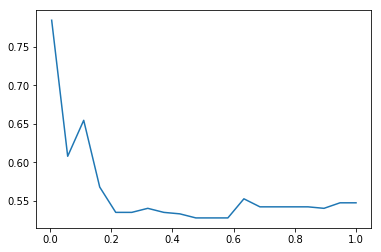

In [80]:
dis_t = []
ls = np.linspace(0.005, 1, num=20)
for rv in tqdm(ls):
    coupling_t = ot.bregman.sinkhorn(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=rv, verbose=False, log=False, m=1)
    XX, yy = partial_repair(1, data_test[gender_test == positive_label], data_test[gender_test == negative_label], coupling_t, y_first, y_second)
    dis_t.append(disparate_impact(clf.predict(XX), gender_test_new))
    
plt.plot(ls, dis_t)

In [79]:
list(zip(ls, dis_t))

[(0.005, 0.7340075632462293),
 (0.01, 0.9141604983718302),
 (0.015, 0.6889411485887112),
 (0.02, 0.6628450334705441),
 (0.025, 0.5784986456206305),
 (0.030000000000000002, 0.5995550626644561),
 (0.034999999999999996, 0.569658285325402),
 (0.04, 0.6449867252530465),
 (0.045, 0.6376573306478984),
 (0.049999999999999996, 0.6571302609641594),
 (0.055, 0.6083397522273054),
 (0.06, 0.5685284280251718),
 (0.065, 0.5770457078457735),
 (0.07, 0.5867373260226578),
 (0.07500000000000001, 0.5599602781358605),
 (0.08, 0.63970084215491),
 (0.085, 0.644492608762812),
 (0.09000000000000001, 0.646915513307033),
 (0.095, 0.7269277098836368),
 (0.1, 0.7269277098836368)]

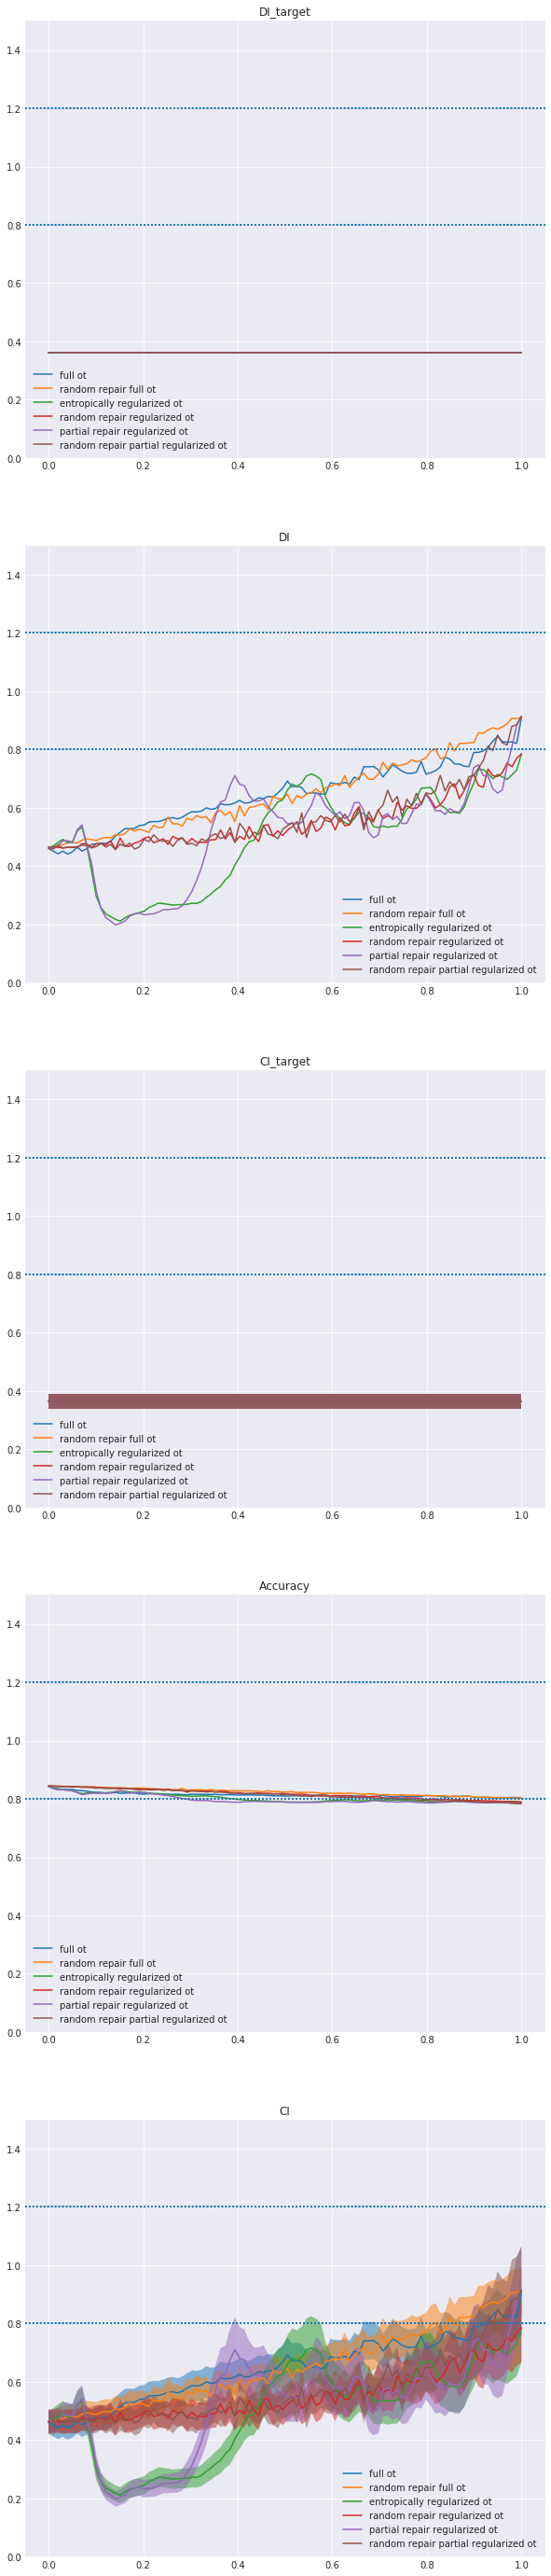

In [81]:
fig, aaaa = plot_metrics([evaluation_1, evaluation_2, evaluation_3, evaluation_4, evaluation_5, evaluation_6])

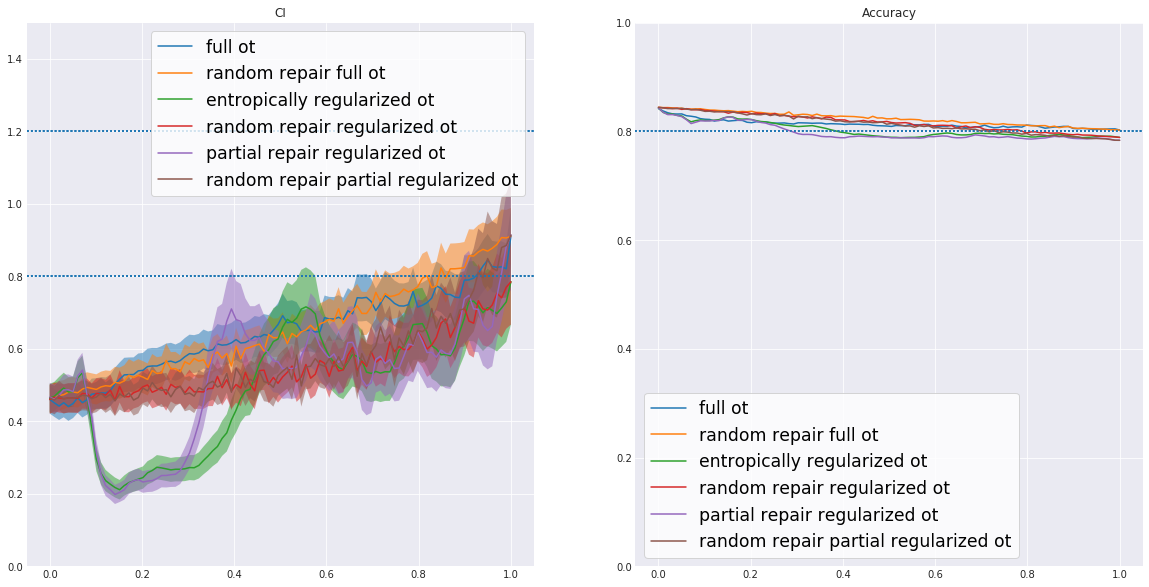

In [92]:
fig, aaaa = plot_metrics([evaluation_1, evaluation_2, evaluation_3, evaluation_4, evaluation_5, evaluation_6], what_to_plot=['CI', 'Accuracy'], subplot_shape=(1, 2), subplot_size=(20, 10))
aaaa[1].set_ylim(0, 1)
aaaa[0].legend(fontsize='xx-large', loc='best')
aaaa[1].legend(fontsize='xx-large', loc='best')

In [85]:
fig.savefig('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/adult_income_tradeoff_gb.pgf', frameon=True, bbox_inches='tight')

In [93]:
with open('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/adult_income_tradeoff_gb.pickle', mode='wb') as file:
    pl.dump(fig, file)